# ASSIGNMENT DATA SCIENCE
## Problem statement
Our road networks are equipped with various sensors that measure traffic. ANPR (Automatic Number Plate Recognition) cameras monitor the road and use character recognition algorithms to detect and read license plates of vehicles. Inductive counting loops on the other hand are placed under the road surface and can detect vehicles passing over them.

In this particular case, the ANPR camera **CPT-C-0002.1** and the inductive counting loop **01A** are located on the same road segment close to each other. This means that we expect these two sensors to produce identical information about the traffic they observe.

The goal of this exercise is to make an analysis in order to demonstrate that (1) the two sensors work fine, or (2) one sensor is working properly and the other not, or (3) both sensors produce erroneous results. The analysis should be focused on the vehicle counts provided by the two sensors, but speed information is also provided and can be used. 

Make use of Python, its libraries and this Jupyter notebook to help you out and visualise your findings. The Jupyter notebook will be used to discuss your analysis, used logic and conclusions with members of the data science team. Every additional bit of useful information about the data is welcome and can be discussed.

We wish you the best of luck! If you have any questions, please use the following email address: bruno.cornelis@macq.eu


## Structure of the data
### Counting loop (*pboc_data_rv.csv*)

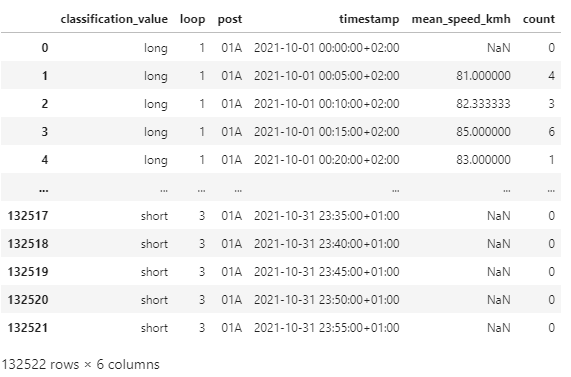

In [1]:
from PIL import Image
Image.open('./images/img_data_pboc_rv.png')

**Features**:
- **classification_value**: classification of the detected vehicle. "short", "medium", "long" represent the length of the vehicle.
- **loop**: id of the loop placed on a single lane of the road. There is one loop on each lane of the road.
- **post**: unique id of the counting post containing the different loops.
- **timestamp**: time of the observation. *Important:* The data is aggregated every 5 minutes.
- **mean_speed_kmh**: average speed of the vehicles detected in km/h.
- **count**: count of the vehicles.

**Explanation for the second row of the Data Frame**:  
There are 4 long vehicles detected by loop 1 of post 01A between 00:05 and 00:10. The average speed of those 4 vehicles equals 81 km/h.  

### ANPR camera (*pfic_data_rv.csv*)

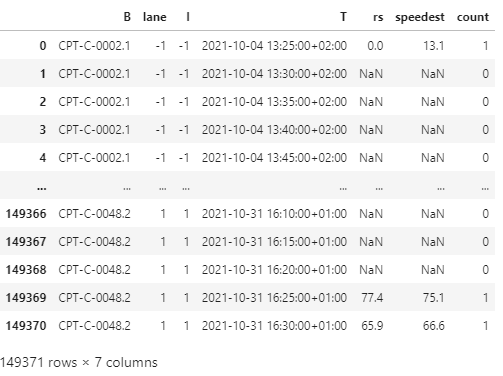

In [2]:
Image.open('./images/img_data_pfic_rv.png')

**Features**:
- **B**: unique ID of a camera
- **lane**: id of the lane observed by the camera (-1:unknown, 1:lane1, 2:lane2). *Be careful:* this camera does not observe traffic on the fastest lane. We don't know if 1 or 2 is the lane in the middle. 
- **l**: classification of the vehicle made by the camera (-1:unknown, 0:short vehicle, 1:long vehicle).
- **T**: time of the observation. The data is aggregated every 5 minutes.
- **rs**: average speed returned by the radar fixed to the camera in km/h.
- **speedest**: speed estimation from the camera in km/h.
- **count**: count of the vehicles.

**Explanation of the last row of the Data Frame**:  
There is 1 long vehicle detected by camera CPT-C-0048.2 on lane 1 between 16:30 and 16:35. The average speed is 65.9 km/h from the radar and 66.6 from the camera 

# Implementation :

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

counting_loop_df = pd.read_csv('pboc_data_rv.csv')
anpr_df = pd.read_csv('pfic_data_rv.csv')

In [4]:
# reformat timestamps
time_format='%Y-%m-%d %H:%M:%S'
anpr_df['T'] = pd.to_datetime(anpr_df['T'].apply(lambda x: x[:-6]), format=time_format)
anpr_df = anpr_df.rename({'T':'timestamp'}, axis='columns')
counting_loop_df['timestamp'] = pd.to_datetime(counting_loop_df['timestamp'].apply(lambda x: x[:-6]), format=time_format)

#print(anpr_df.dtypes)
#print(counting_loop_df.dtypes)

# set timestamps as index
# anpr_df = anpr_df.rename({'T':'timestamp'}, axis='columns').set_index('timestamp')
# counting_loop_df = counting_loop_df.set_index('timestamp')

### Counting Loop NaN

In [5]:
# check NaN values in counting_loop_df

na_count = [(column,counting_loop_df[column].isna().sum()) for column in counting_loop_df.columns]

na_count0 = [(column,counting_loop_df[counting_loop_df['count']==0][column].isna().sum()) for column in counting_loop_df.columns]

print(na_count)

print(na_count0)

# NaN values in mean_speed_kmh only where count=0 --> it's consistent

counting_loop_df = counting_loop_df[counting_loop_df['count']!=0] # drop entries where count=0


[('classification_value', 0), ('loop', 0), ('post', 0), ('timestamp', 0), ('mean_speed_kmh', 62309), ('count', 0)]
[('classification_value', 0), ('loop', 0), ('post', 0), ('timestamp', 0), ('mean_speed_kmh', 62309), ('count', 0)]


In [6]:
# [counting_loop_df[column].value_counts() for column in counting_loop_df.columns] 

### ANPR NaN

In [7]:
# check NaN values in anpr_df

na_count = [(column,anpr_df[column].isna().sum()) for column in anpr_df.columns]

na_count0 = [(column,anpr_df[anpr_df['count']==0][column].isna().sum()) for column in anpr_df.columns]

print(na_count)

print(na_count0)

# NaN values in rs and speedest only where count=0 --> it's consistent

anpr_df = anpr_df[anpr_df['count']!=0] # # drop entries where count=0

[('B', 0), ('lane', 0), ('l', 0), ('timestamp', 0), ('rs', 70008), ('speedest', 70008), ('count', 0)]
[('B', 0), ('lane', 0), ('l', 0), ('timestamp', 0), ('rs', 70008), ('speedest', 70008), ('count', 0)]


In [8]:
# [anpr_df[column].value_counts() for column in anpr_df.columns]

# Many issues in the anpr dataset at first sight (even after removing null count) :

# ~8% of the lanes are undetected
# ~30% of the vehicles types are undected
# most of the radar speeds are nulls -> missdetection ? traffic jam ?
# most of the camera speeds are incoherents -> -1 , -2 , -1.288, 0, ...

In [9]:
# Let's first trim any entries with incoherents speeds
# anpr_df = anpr_df[(anpr_df.speedest > 0) & (anpr_df.rs > 0)]

# Let's also remove the speeds outliers 
anpr_df = anpr_df[(anpr_df.speedest < 300) & (anpr_df.rs < 300)]

# 1) Count comparison : ANPR CPT-C-0002.1 vs LOOP 01A

First, we'll remove the fastest lane from the loop dataframe to match the anpr dataframe

Plot for lane 1, the mode of the distribution is 86.0 km/h, the mean is 98.7894152477034 km/h
Plot for lane 2, the mode of the distribution is 90.0 km/h, the mean is 112.59488165821136 km/h
Plot for lane 3, the mode of the distribution is 123.0 km/h, the mean is 123.6668818015429 km/h


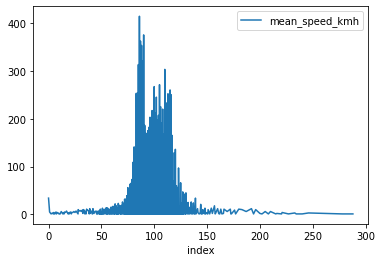

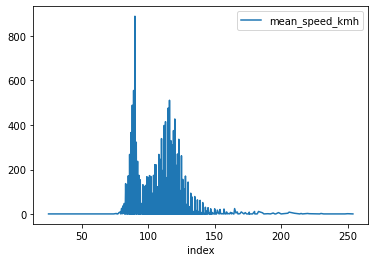

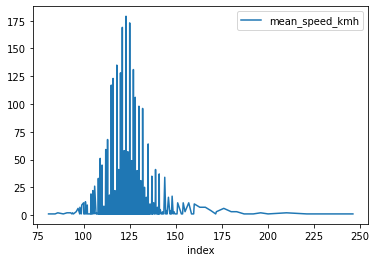

In [10]:
# delete outliers
counting_loop_df = counting_loop_df[counting_loop_df['mean_speed_kmh']<300]


for lane in counting_loop_df.loop.unique():
    temp_df = counting_loop_df[counting_loop_df.loop == lane]
    sp = temp_df.mean_speed_kmh
    print(f'Plot for lane {lane}, the mode of the distribution is {sp.mode()[0]} km/h, the mean is {sp.mean()} km/h')
    speed_distribution = pd.DataFrame(temp_df['mean_speed_kmh'].value_counts())
    speed_distribution.sort_index().reset_index().plot(x ='index', y=['mean_speed_kmh'], kind = 'line')

The fastest lane is the third one

In [11]:
counting_loop_df = counting_loop_df[counting_loop_df.loop != 3]

We'll also trim counting_loop_df to match anpr_df timeframes

In [12]:
counting_loop_df = counting_loop_df[(counting_loop_df.timestamp >= "2021-10-04 13:25:00") & (counting_loop_df.timestamp <= "2021-10-31 16:30:00")]

Now we'll trim the ANPR dataframe to only keep the CPT-C-0002.1 camera and the loop dataframe to only keep the 01A

In [13]:
anpr_df = anpr_df[(anpr_df.B == 'CPT-C-0002.1')]

counting_loop_df = counting_loop_df[(counting_loop_df.post == '01A')]

Now we build a function to effectively extract and compare the count values for selected days and time scale

<AxesSubplot:title={'center':'diff 21th of October, T = 30min'}, xlabel='timestamp'>

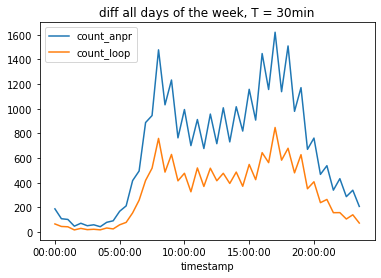

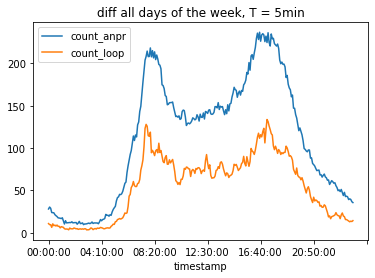

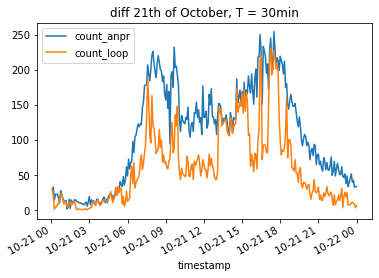

In [14]:
def get_count_df(anpr: pd.DataFrame, loop: pd.DataFrame, starting_time: str = "2021-10-04 13:25:00", end_time: str = "2021-10-31 16:30:00", days: list = None, date_collapse : bool = False, scale: str = None):
    """
    :param anpr: (pd.DataFrame) ANPR related datas
    :param loop: (pd.DataFrame) inductive loop related datas
    :param starting_time: OPTIONAL (str) time from which the data trimming begins
    :param end_time: OPTIONAL (str) time at which the data trimming ends
    :param days: OPTIONAL (list) list of strings of days to trim from the df
    :param date_collapse: OPTIONAL (bool) if True only considers the time of the day of each entries and regroup data
    :param scale: OPTIONAL (string) string denoting at which value the TimeStamps should be rounded,'T':minutes, 'H':hours, 'D':day,...
    :return: (pd.DataFrame) requested counts for both sensors
    """
    # select entries from requested timeframes
    reduce_anpr = anpr[(anpr['timestamp'] > starting_time) & (anpr['timestamp'] <= end_time)]
    # collapse entries on the count values and sum
    anpr_ = pd.DataFrame(reduce_anpr.groupby('timestamp')['count'].sum())
    
    reduce_loop = loop[(loop['timestamp'] > starting_time) & (loop['timestamp'] <= end_time)]
    loop_ = pd.DataFrame(reduce_loop.groupby('timestamp')['count'].sum())
    
    # merge the results
    comparison = anpr_.merge(loop_, on='timestamp', suffixes=['_anpr','_loop']).reset_index()
    
    if days is not None:
        # if needed, select relevant days of the weeks
        comparison = comparison[comparison['timestamp'].dt.day_name().isin(days)]
    
    if scale is not None:
        # if needed, rescale the timestamps and groupby again
        comparison['timestamp'] = comparison['timestamp'].dt.round(scale)
        comparison = comparison.groupby('timestamp')['count_anpr','count_loop'].sum().reset_index()
    
    if date_collapse:
        # if True, will regroup entries by the time of the day (for all the dates)
        comparison['timestamp'] = comparison['timestamp'].dt.strftime('%H:%M:%S')
        comparison = comparison.groupby('timestamp').agg({'count_anpr':['mean','std'],'count_loop':['mean','std']}).reset_index()
        comparison.columns = ['timestamp','count_anpr','std_anpr','count_loop','std_loop']
    return comparison

# examples :

# return a dataframe comparing the counts the day of the 12th of October, rescaled on every 2 hours
get_count_df(anpr_df, counting_loop_df, starting_time = "2021-10-12 00:00:00", end_time = "2021-10-13 00:00:00", scale = "2H")

# return a dataframe comparing the counts for all satarudays and sundays, rescaled on every 15 minutes
get_count_df(anpr_df, counting_loop_df, days = ['Saturday','Sunday'], scale = "15T")

# plot the comparison between anpr and loop counts for all days of the week (collapsed), rescaled on every 30 minutes
days_of_week = ['Monday','Tuesday','Wednesday','Thursday','Friday']
get_count_df(anpr_df, counting_loop_df, days = days_of_week, date_collapse = True, scale = "30T").plot(x ='timestamp', y=['count_anpr','count_loop'], kind = 'line', title = 'diff all days of the week, T = 30min')

# plot the comparison between anpr and loop counts for a all days of the week (collapsed), with no rescaling
get_count_df(anpr_df, counting_loop_df, days = days_of_week, date_collapse = True).plot(x ='timestamp', y=['count_anpr','count_loop'], kind = 'line', title = 'diff all days of the week, T = 5min')

# plot the comparison between anpr and loop counts for a specific day, with no rescaling
get_count_df(anpr_df, counting_loop_df, starting_time = "2021-10-21 00:00:00", end_time = "2021-10-22 00:00:00").plot(x ='timestamp', y=['count_anpr','count_loop'], kind = 'line', title = 'diff 21th of October, T = 30min')

# ... repeat the tests for any parameters you want ... (not displaying all I did for readability purpose, just some examples here)

We can plot the count differences for different days, scales, etc... We obviously see a difference between the two counts, but how to assess it ? Is there a metric that can tell us 'how far' these distributions are ?
<br /> --> We'll use [Kolmogorov Smirnov test](https://en.m.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test). It tests the **Null Hypothesis** that the two distributions are identical.

In [15]:
from math import sqrt, log1p
from scipy import stats

# compare distributions of all days of the week, collapsed
df = get_count_df(anpr_df, counting_loop_df, days = days_of_week, date_collapse = True)
n = len(df)
D = stats.kstest(df.count_loop, df.count_anpr)[0]
confidence = 0.9975 
bound = sqrt(log1p(2/(1-confidence))*(1/n))
print(n,D,bound)
if D > bound : 
    print(f'The null hypothesis is rejected with a confidence of {confidence*100} %')
    
# compare distributions of all predictions
df = get_count_df(anpr_df, counting_loop_df, scale = "H")
n = len(df)
D = stats.kstest(df.count_loop, df.count_anpr)[0]
confidence = 0.9975 
bound = sqrt(log1p(2/(1-confidence))*(1/n))
print(n,D,bound)
if D > bound : 
    print(f'The null hypothesis is rejected with a confidence of {confidence*100} %')

# compare distributions of all predictions during the week, collapsed and rescaled for every 30 minutes
df = get_count_df(anpr_df, counting_loop_df, days = days_of_week, date_collapse = True, scale = "30T")
n = len(df)
D = stats.kstest(df.count_loop, df.count_anpr)[0]
confidence = 0.9975
bound = sqrt(log1p(2/(1-confidence))*(1/n))
print(n,D,bound)
if D > bound : 
    print(f'The null hypothesis is rejected with a confidence of {confidence*100} %')
    

# ... repeat the tests for any parameters you want ... (not displaying all I did for readability purpose)

288 0.5173611111111112 0.1523640211962737
The null hypothesis is rejected with a confidence of 99.75 %
651 0.4470046082949309 0.10134169775387654
The null hypothesis is rejected with a confidence of 99.75 %
48 0.5 0.3732141070894711
The null hypothesis is rejected with a confidence of 99.75 %


The tests reject the **Null Hypothesis** (*= the two distributions are equals*) when we are looking for precise distribution (specific day or high-scale) and also when aggregating the results and looking at the bigger picture. <br />
What can we interpret ? -> One (or two) sensors have a consistent error from one to the other

<br /><br />
(It is important to do the Kolmogorov Smirnov test with different parameters to be sure that noise isn't responsible for the difference)

Mean Standard Deviation on every 15 minutes blocks : anpr = 10.318267697752999, loop = 10.016933208521902


<AxesSubplot:title={'center':'normalized difference'}, xlabel='timestamp'>

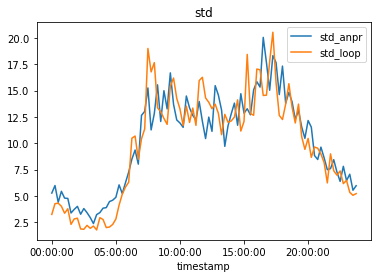

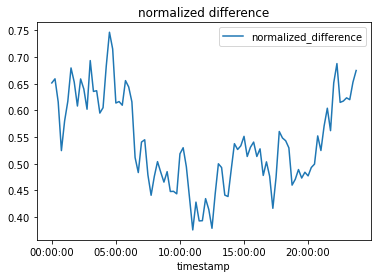

In [16]:
# retrieve all entries
comp = get_count_df(anpr_df, counting_loop_df)

# compute standard deviation on every block of 15 minutes
comp['timestamp'] = comp['timestamp'].dt.round('15T')
comp = comp.groupby('timestamp').agg({'count_anpr':['sum','std'],'count_loop':['sum','std']}).reset_index()
comp.columns = ['timestamp','count_anpr','std_anpr','count_loop','std_loop']
print(f'Mean Standard Deviation on every 15 minutes blocks : anpr = {comp.std_anpr.mean()}, loop = {comp.std_loop.mean()}')

# adds normalized difference and collapses all entries by time of the day
comp['normalized_difference'] = (comp['count_anpr']-comp['count_loop'])/(comp['count_anpr'])
comp['timestamp'] = comp['timestamp'].dt.strftime('%H:%M:%S')
comp = comp.groupby('timestamp').mean().reset_index()
comp.plot(x ='timestamp', y=['std_anpr','std_loop'], kind = 'line', title = 'std')
comp.plot(x ='timestamp', y=['normalized_difference'], kind = 'line', title = 'normalized difference')

Two importants takes from these graphs : <br/>
1) The standard deviations are similars for these two sensors <br/>
2) The loop sensor is consistently underestimating (from the ANPR) the number of vehicles (between ~40% and ~75%) <br/>

Admitting that the ANPR only adds a count when it correctly detect a vehicle plate (thus reducing the possibility of false positive), **we can suppose that the inductive counting loop struggles to detect all vehicles passing by this portion of road**.


In [17]:
# (commented for readability purpose)
#for day in ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']:
#    count = get_count_df(anpr_df, counting_loop_df, days = [day], date_collapse = True)
#    count.plot(x ='timestamp', y=['count_anpr','std_anpr','count_loop','std_loop'], kind = 'line', title = day)
#    print(f'Average standard deviation of the counting loop during {day} = {count.std_loop.mean()}')
#    print(f'Average standard deviation of the ANPR during {day} = {count.std_anpr.mean()} \n')


In [18]:
# all comparisons : (commented for readability purpose)
# for i in range(26):
#     get_count_df(anpr_df, counting_loop_df, starting_time = f"2021-10-{5+i} 00:00:00", end_time = f"2021-10-{6+i} 00:00:00").plot(x ='timestamp', y=['count_anpr','count_loop'], kind = 'line')


<AxesSubplot:title={'center':'diff 21th of October, T = 30min'}, xlabel='timestamp'>

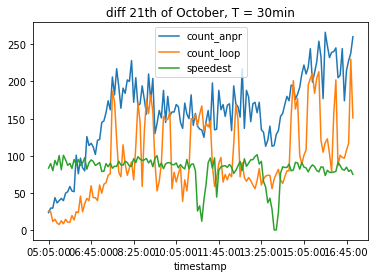

In [19]:
# tried to find a link between ANPR & loop count match AND the average vehicles speed, for different dates but gave nothing
# (change dates for different days/time)
starting_time = "2021-10-15 05:00:00"
end_time = "2021-10-15 17:00:00"

p = get_count_df(anpr_df, counting_loop_df, starting_time = starting_time, end_time = end_time)
p['timestamp'] = p['timestamp'].dt.strftime('%H:%M:%S')
feature = 'speedest'
temp_df = anpr_df[(anpr_df.timestamp >= starting_time) & (anpr_df.timestamp <= end_time)].copy()
temp_df[feature] = temp_df[feature] * temp_df['count']
temp_df['timestamp'] = temp_df['timestamp'].dt.strftime('%H:%M:%S')
temp_df = temp_df.groupby('timestamp')['count',feature].sum().reset_index()
temp_df[feature] = temp_df[feature] / temp_df['count']
temp_df = temp_df.merge(p, on='timestamp', suffixes=['_a','_l']).reset_index()
temp_df.plot(x ='timestamp', y=['count_anpr','count_loop',feature], kind = 'line', title = 'diff 21th of October, T = 30min')

What if we look at the vehicle type ?

<AxesSubplot:title={'center':'diff all days of the week (long vehicles), T = 30min'}, xlabel='timestamp'>

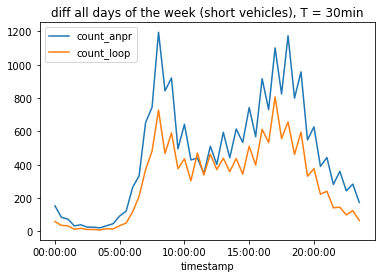

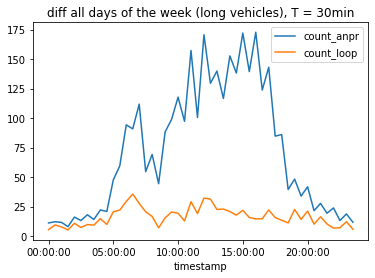

In [20]:
get_count_df(anpr_df[anpr_df.l == 0], counting_loop_df[counting_loop_df.classification_value=='short'], days = days_of_week, date_collapse = True, scale = "30T").plot(x ='timestamp', y=['count_anpr','count_loop'], kind = 'line', title = 'diff all days of the week (short vehicles), T = 30min')

get_count_df(anpr_df[anpr_df.l == 1], counting_loop_df[counting_loop_df.classification_value=='long'], days = days_of_week, date_collapse = True, scale = "30T").plot(x ='timestamp', y=['count_anpr','count_loop'], kind = 'line', title = 'diff all days of the week (long vehicles), T = 30min')

We see that the difference in average count for week days is way closer for short vehicles and desastrous for long vehicles.<br/>
**We could hypothetize that the inductive counting loop struggles to detect long vehicles, thus explaining the difference in count between the two sensors**.

# 2) ANPR Speed Default Analysis

An problem in the speed distribution of the anpr has been found :

The mode of the distribution is 87.5 km/h, the mean is 104.25303027377844 km/h


<AxesSubplot:xlabel='index'>

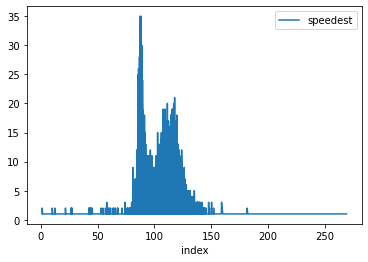

In [21]:
sp = anpr_df[anpr_df.speedest>1].speedest
print(f'The mode of the distribution is {sp.mode()[0]} km/h, the mean is {sp.mean()} km/h')
speed_distribution = pd.DataFrame(sp.value_counts())
speed_distribution.sort_index().reset_index().plot(x ='index', y=['speedest'], kind = 'line')

<AxesSubplot:xlabel='timestamp'>

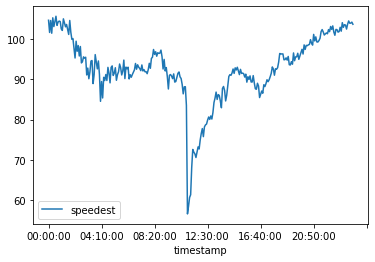

In [22]:
feature = 'speedest'
temp_df = anpr_df.copy()
temp_df[feature] = temp_df[feature] * temp_df['count']
temp_df['timestamp'] = temp_df['timestamp'].dt.strftime('%H:%M:%S')
temp_df = temp_df.groupby('timestamp')['count',feature].sum().reset_index()
temp_df[feature] = temp_df[feature] / temp_df['count']
temp_df.plot(x ='timestamp', y=[feature], kind = 'line')

What causes this huge drop in average speed around the middle of the day ?

In [23]:
print(anpr_df.speedest.value_counts())
print(anpr_df.rs.value_counts())

-1.000000      8786
-2.300000       607
-1.650000       521
-3.600000       499
-1.866667       493
               ... 
 101.265556       1
 97.201220        1
 100.630682       1
 99.110891        1
 144.000000       1
Name: speedest, Length: 22808, dtype: int64
0.000000      2906
90.000000       52
91.300000       50
89.400000       47
90.500000       47
              ... 
107.867347       1
110.856818       1
108.276596       1
107.369492       1
39.866667        1
Name: rs, Length: 28041, dtype: int64


It can be seen that the most common entries for the **ANPR** average speed for both speedest and rs are incoherents (-1, 0 ..)

When removing these incoherents values we observe sharp spikes during the days <br/>
--> many of the **ANPR** entries in the middle of the day are affected by this

In [24]:
# examples of shuch entries
print(anpr_df[(anpr_df.speedest <= 0)])
print(anpr_df[(anpr_df.speedest <= 0)].lane.value_counts())

                  B  lane  l           timestamp          rs  speedest  count
3495   CPT-C-0002.1    -1 -1 2021-10-16 16:40:00   91.800000 -3.600000      1
4848   CPT-C-0002.1    -1 -1 2021-10-21 09:25:00    0.000000 -3.600000      1
16535  CPT-C-0002.1    -1  1 2021-10-01 00:40:00    0.000000 -1.000000      1
16551  CPT-C-0002.1    -1  1 2021-10-01 02:00:00    0.000000 -1.000000      1
16560  CPT-C-0002.1    -1  1 2021-10-01 02:45:00    0.000000 -1.000000      1
...             ...   ... ..                 ...         ...       ...    ...
78320  CPT-C-0002.1     2  1 2021-10-29 11:00:00   90.250000 -2.300000      2
78323  CPT-C-0002.1     2  1 2021-10-29 11:15:00   92.000000 -2.300000      2
78326  CPT-C-0002.1     2  1 2021-10-29 11:30:00  111.800000 -1.000000      1
78331  CPT-C-0002.1     2  1 2021-10-29 11:55:00   91.400000 -2.300000      2
78339  CPT-C-0002.1     2  1 2021-10-29 12:35:00   94.366667 -1.866667      3

[16777 rows x 7 columns]
 2    7717
 1    6427
-1    2633
Name:

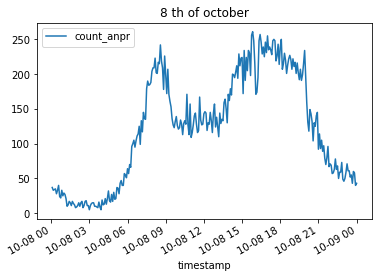

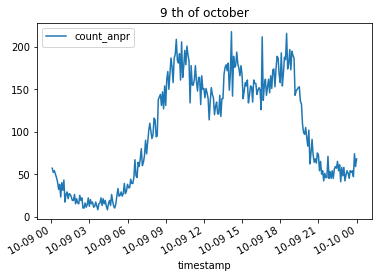

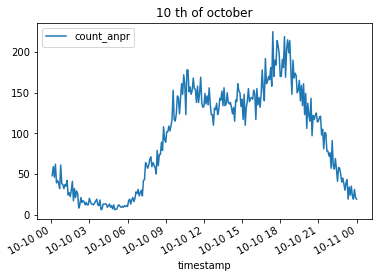

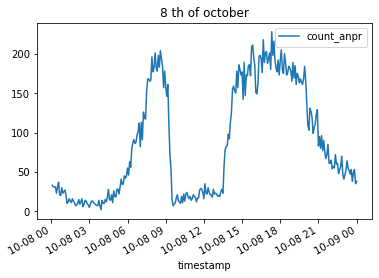

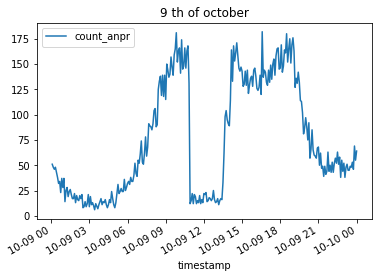

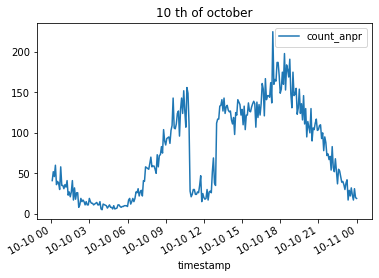

In [25]:
for i in range(3):
    get_count_df(anpr_df, counting_loop_df, starting_time = f"2021-10-{8+i} 00:00:00", end_time = f"2021-10-{9+i} 00:00:00").plot(x ='timestamp', y=['count_anpr'], kind = 'line', title = f'{8+i} th of october')
anpr_df = anpr_df[(anpr_df.speedest > 0)]
for i in range(3):
    get_count_df(anpr_df, counting_loop_df, starting_time = f"2021-10-{8+i} 00:00:00", end_time = f"2021-10-{9+i} 00:00:00").plot(x ='timestamp', y=['count_anpr'], kind = 'line', title = f'{8+i} th of october')

The entries affected by incoherent average speed values have also a large amount of unknown vehicles length or lane. How can we be sure that it doesn't also affect the vehicles counting capabilities of the ANPR ? <br/>
And how can we explain that this phenomonen is so localised in time ? The ANPR being directly hit by sunlights ?

# 3) Feature Analysis

# 4) Forecasting